# Recommender System based on a purchase history 1

## Introduction

A recommender system is one of the important features for almost all web services such as online shops and important for both the website owners and visitors because

- The website owners want visitors to stay on their website (and to click ads or "add to cart" button).
- The visitors (customers) want to find/read an interesting webpage/article/product (item).

The easiest recommendation is the most popular items. Such a recommender system is easy to implement. Moreover it is effective because the popularity means by definition that many people are likely to be interested in the items. But such a recommender system ignores personal preferences, even though the website owners know visitors through historical data such as a purchase history.

The aim of this document is to implement several recommender systems for a particular dataset and to measure the performance of the recommender systems.

## Before discussion

- This document is written for people who understand linear algebra and Python.
- The implementation is very naive and we may make it more efficient.
- Most of functions can be found in the module `binarycf.py`, which can be found in the repository as this document.
- The performance of recommender systems depends on the dataset we use to train a model. Thus the conclusion of this document does not extend to other datasets.

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import binarycf as bcf ## you can find this in this repository!

%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5 ## width, height (inches)

## Data

The data which we are going to look at is provided for [Data Analysis Using SQL and Excel](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-111902143X.html). We use (small part of) Purchases Dataset, which was probably artificially generated. Unfortunately there is no detailed information about items.

NB: Since `orders.txt` contains strange letters, we fail to import the dataset directly. To avoid the unwanted letters we convert the text file by `nkf -w orders.txt > orders.csv`. (The conversion actually fails, but it is OK because we do not use the column containing the unwanted letters.)

In [2]:
df_customers = pd.read_csv('purchase-data/customers.txt',sep='\t')[['customerid','householdid']]
df_orderlines = pd.read_csv('purchase-data/orderlines.txt',sep='\t')[['orderid','productid']]
df_orders = pd.read_csv('purchase-data/orders.csv',sep='\t')[['customerid','orderid']]
df_products = pd.read_csv('purchase-data/products.txt',sep='\t')[['PRODUCTID','PRODUCTGROUPNAME']]

The dataset contains the purchase history of the customers. In this document we only use the three variables: 

- `customer` : customer ID. This is originally called `householdid` in the dataset.
- `category` : category of the item. There are 8 categories.
- `item` : a product ID

**We merge the multiple purchases of the items with the same product ID**. 

The following table describes all purchases in the dataset. 

Remark: By the second merging we lost records without householdid. This is OK because the customers without householdid have `customerid=0`, therefore we can not distinguish them. 

In [3]:
#dg = pd.read_csv('purchase-data/orders.csv',sep='\t')
#dg[dg.customerid==0].groupby('customerid').size()

In [4]:
df = pd.merge(df_orderlines,df_orders,on='orderid') ## add customerid
df = pd.merge(df,df_customers,on='customerid')      ## add householdid
df = pd.merge(df,df_products,left_on='productid',right_on='PRODUCTID') ## add PRODUCTGROUPNAME
df = df[['householdid','PRODUCTGROUPNAME','productid']].copy()
df.rename(columns={'householdid':'customer','PRODUCTGROUPNAME':'category','productid':'item'},
          inplace=True)
df.category = df.category.fillna('OTHER') ## fill NA
df.to_csv('df_long.csv',index=False)
df.head(5)

,customer,category,item
0,18335614,BOOK,10834
1,36189356,BOOK,10834
2,36212313,BOOK,10834
3,20327232,BOOK,10834
4,20169475,BOOK,10834


To understand the dataset we see some simple two kinds of numbers. The one is: How many items are in each category?

- The number of items in ARTWORK is very large in comparison with other categories.
- BOOK and GAME follow ARTWORK. Other categories contain less than 100 items.

In [5]:
## How many items are in each category?
df.groupby(['category','item']).size().reset_index().groupby('category').size()

category
APPAREL       86
ARTWORK     3251
BOOK         239
CALENDAR      31
FREEBIE       25
GAME         231
OCCASION      71
OTHER         56
dtype: int64

The another is: How many customers are in each category?

- Even though the number of items in BOOK is very smaller than in ARTWORK, the number of customers in BOOK is largest. Around twice of the number of customers in ARTWORK.
- A similar phenomenon also happens to CALENDAR and OCCASION.

In [6]:
## number of customers in each category
df.groupby(['category','customer']).size().reset_index().groupby('category').size()

category
APPAREL      9934
ARTWORK     38726
BOOK        74422
CALENDAR     6400
FREEBIE     20698
GAME        10699
OCCASION    33730
OTHER        4516
dtype: int64

## Out mission

### What kind of recommender system do we construct?

Let us assume that our shop is an online shop (like Amazon) and we want to show recommendations at the top page of the website. Thinking about the display, we are going to **recommend 5 items**.

There are many kinds of recommender systems in an algorithm level. The famous ones are the user-based collaborative filtering (UBCF) and the item-based collaborative filtering (IBCF). We want to apply them, but there is a problem to solve: Both UBCF and IBCF are for ratings. 

A typical situation of applying UBCF/IBCF is following: Some customers give a rating (say 1 to 5) to items. Our task is to predict a rating of the items which a customer has not rated. (See the [image from Wikipedia](https://en.wikipedia.org/wiki/File:Collaborative_filtering.gif).)

But we have a purchase history and no rating. What we know is: who buys which item. We may assume that a customer rates positively the items which he buys, but there are two cases for items which he does not buy.

- He is not interested in the item (negarive rating).
- He does not know the item (no rating).

And we can not distinguish them from the dataset.

So we assume that 

- If a customer buys nothing in the cateogry C, then he does not know anything about the category C. (no rating)
- If a customer buys something in the category D, then he is not interested in the items in the category D except the items which he buys. (rating = 0)

Therefore our mission is: **Make a recommendation of items in the categories which a customer does not know**.

### Make the mission clear by looking at our data

By the following code we know that around 35,000 customers buy items in two or more categories. We use the purchase history of the customers to construct our recommender system.

In [7]:
## In how many categories a customer buy products?
df.groupby(['customer','category']).size().reset_index().groupby('customer').size().value_counts()

1    121309
2     28719
3      4908
4      1035
5       227
6        45
7        11
8         4
dtype: int64

The following table is just for the next code.

In [8]:
## the wide table of customer x category
df_cats = df[['customer','category']].copy()
df_cats['val'] = 1
df_cats = df_cats.pivot_table(index='customer', columns='category', values='val',
                              aggfunc=lambda x: 1, fill_value=0)
df_cats.iloc[5:10,:]

category,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER
customer,,,,,,,,
18111926,0,1,0,0,0,0,0,0
18111966,0,0,1,0,0,0,0,0
18112052,0,0,0,1,1,0,0,0
18112318,0,0,1,0,0,0,0,0
18112322,0,0,1,0,1,0,0,0


The following crosstab shows the number of customers in the corresponding categories. For example

- 600 customers buy an item in APPAREL and an item in ARTWORK.
- 1308 customers buy an item in APPAREL and an item in BOOK.
- 38726 customers buy an item in ARTWORK.

What we want to do is:

- There are 9334 (=9934-600) customers who buy an item in APPAREL but no items in ARTWORK.
- We want to recommend 5 items in ARTWORK to such customers.
- To construct a recommender system we use the purchase history of the 600 customers.

In [9]:
df_catxcat = pd.concat([df_cats[df_cats[cat]==1].apply(np.sum) for cat in df_cats.columns],axis=1)
df_catxcat.columns = df_cats.columns
df_catxcat

category,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER
category,,,,,,,,
APPAREL,9934,600,1308,294,1405,318,529,373
ARTWORK,600,38726,5691,393,4257,552,3781,644
BOOK,1308,5691,74422,1196,6982,1946,4892,1307
CALENDAR,294,393,1196,6400,943,354,420,270
FREEBIE,1405,4257,6982,943,20698,2925,8318,1335
GAME,318,552,1946,354,2925,10699,706,401
OCCASION,529,3781,4892,420,8318,706,33730,801
OTHER,373,644,1307,270,1335,401,801,4516


The following table shows (very small part of) the customers who buy items in APPAREL and in ARTWORK. A recommender system which we want is nothing but a predictive model whose feature variable is APPAREL and target variable is ARTWORK.

In [10]:
df_common = pd.merge(bcf.customer_in_cat(df,'APPAREL'), bcf.customer_in_cat(df,'ARTWORK'),
                     on='customer')
df_common.head()

,customer,APPAREL,ARTWORK
0,18133034,{11153},"{11009, 11054}"
1,18140332,"{10948, 10950}",{12511}
2,18148824,{13973},{13317}
3,18155345,"{13152, 11124}",{12237}
4,18159475,{11153},{11054}


Remarks

- Our training data is definitely biased in the sense that the customers who buys an item in ARTWORK are interested in items in ARTWORK. The customers who we show recommendations might not be interested in ARTWORK, because they have not bought anything in ARTWORK.
- Because the purchase history has been taken for several years, most items in CALENDAR must be only for a specific year. But we ignore this fact.

## Construct recommender systems

### How to measure the performance of a recommender system

When constructing a recommender system (or a predictive model), it is important to measure the performance of a trained model. Because our recommender system recommends 5 items, **the recommendation is success if any items which a customer buy is contained in the recommended items**. We use the success rate as the performance of a model.

To illustrate our model we look at the customers who buy items in APPAREL and ARTWORK. We split the data into training set and test set and we use the latter to measure the performance.

Remark: We measure the performance of the model by CV later. 

In [11]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_common, df_common.ARTWORK,
                                                 test_size=0.2, random_state=4)
df_train = X_train.copy() # data frame containing customer IDs
df_test = X_test.copy() 
X_train = df_train.APPAREL # series of sets of products in APPAREL
X_test = df_test.APPAREL

### (Global) popular Items

As the baseline we create a recommender system which recommends top 5 popular items. The top 5 items are easy to find.

In [12]:
popular_items = bcf.get_popular_items(y_train)
popular_items ## top 5 items in ARTWORK

{11009, 11048, 11053, 11054, 12511}

In [13]:
df_compare = pd.DataFrame(y_train)
df_compare['success'] = df_compare.ARTWORK.apply(lambda r: len(r.intersection(popular_items))>0)
df_compare.tail()

,ARTWORK,success
456,{11053},True
360,"{10012, 13317, 13372}",False
439,"{11059, 11052}",False
174,{12825},False
122,{11009},True


This recommender system does a quite good job and its success rate is 32.5%. Namely at least one item in the recommendation is bought by the customer at probability 32.5%.

Remark: This *does not mean* that a customer who buys nothing in ARTWORK will be interested in the recommendation at probability 32.5%.

In [14]:
## using popular items 
y_test.apply(lambda x: len(x.intersection(popular_items))>0).mean()

0.32500000000000001

### User-based collaborative filtering (UBCF)

The idea of the UBCF is: to recommend items which similar customers buy.

#### How to compute the similarity of two customers

Use the purchase history!

Let us look at small part of the purchase history. In the following table each row describes a customer and each column describes an item. Namely each row describes the items which the customer buys.

- The customers 112, 138 and 339 are similar because their purchase history is the same.
- The customer 14 and 112 are not similar, because they have no common items.
- The customer 513 and 556 are quite similar because they buy the item 11016.

In [15]:
df_tmp = defaultdict(list)
df_head = pd.DataFrame(X_train[:10]).reset_index()
for i in range(df_head.shape[0]):
    row = df_head.iloc[i]
    for x in row[1]:
        df_tmp['customer'].append(row[0])
        df_tmp['item'].append(x)

df_tmp = pd.DataFrame(df_tmp,columns=['customer','item'])
df_tmp['val'] = '1'
df_tmp.pivot(index='customer',columns='item',values='val').fillna('0')

item,10948,11016,11153,11155,12510,13144,13149,13963,13973
customer,,,,,,,,,
14,0,0,0,0,0,1,0,0,0
112,0,0,1,0,0,0,0,0,0
117,0,0,0,0,1,0,0,0,0
138,0,0,1,0,0,0,0,0,0
336,0,1,0,0,0,0,0,0,0
369,0,0,0,1,0,0,0,0,0
399,0,0,1,0,0,0,0,0,0
513,0,1,0,0,0,0,0,0,0
556,1,1,0,0,0,0,1,0,0


So we describe a customer with his purchase history. In our case it is a binary vector. Here are two vectors corresponding to two customers:

$$\vec u = (u_1, \cdots, u_n) = (0,1,0,0,0,1,0,0,\cdots,0),$$ 
$$\vec v = (v_1, \cdots, v_n) = (1,0,0,0,1,1,1,0,\cdots,0).$$

There are several ways to measure the similarity degree of two customers:

- common similarity: the number of the common items. It can be calculated by the dot product $\vec u \cdot \vec v$.
- cosine similarity: cosine of the angle of the two vectors. The *normalised common similarity* in the sense that it is given by $\vec u \cdot \vec v / (|\vec u||\vec v|)$.
- correlation: the ordinary correlation of two vectors. Or the cosine similarity of the centered vectors.
- distance: for example Euclidean metric.

Here we choose the common similarity. (We also use the cosine similarity later.)

#### How to make a recommendation

Given a customer, we make a recommendation as follows.

1. Compute the similarity degree between the customer and each customer in the training set.
2. Pick the $k$ nearest customers. ($k$ is arbitrary, say 30.)
3. Add up the vectors corresponding the nearest customers. (The sum describes the frequency of items.)
4. Pick the items corresponding to the 5 largest components of the sum.

The picked 5 items are nothing but the 5 most popular items among the similar customers. (So UBCF is a *local* popular item model.)

In [16]:
yhat = X_test.apply(lambda x: bcf.ubcf(x,X_train,y_train,k=30)) ## make a recommendation
df_compare = pd.concat([yhat,y_test],axis=1).rename(
                columns={'APPAREL':'Recommendation','ARTWORK':'Purchased_item'})
df_compare['success'] = df_compare.apply(lambda r:len(set.intersection(r[0],r[1]))>0,axis=1)
df_compare.tail()

,Recommendation,Purchased_item,success
480,"{10640, 11009, 10795, 13317, 13981}","{11832, 11536}",False
213,"{12171, 11043, 13317, 13454, 12511}",{10538},False
467,"{11048, 11023, 11052, 11054, 11047}","{10772, 11838}",False
379,"{11048, 11009, 12826, 11053, 10109}",{11009},True
579,"{11053, 13623, 13317, 13981, 12511}",{13623},True


The success rate is better than the "global popular items" model. It achieves 38.3%. 

In [17]:
## User-based collaborative filtering
bcf.success_rate(yhat,y_test)

0.38333333333333336

Remark: UBCF requires much calculation (for similarity degree) when making a recommendation.

### Item-based collaborative filtering (IBCF)

The idea of IBCF is: to recommend items which are similar to the items which the customer buys.

#### How to compute the similarity of two items

Use the purchase history!

The calculation is very similar to the similarity of two customers. Let us look at the following table which is the same as above. We describe an item as a column vector corresponding to the item. For example the items 10948 and 13149 are very similar.

We can use the same formulas to compute the similarity degree.

In [18]:
df_tmp.pivot(index='customer',columns='item',values='val').fillna('0') ## the same as before!

item,10948,11016,11153,11155,12510,13144,13149,13963,13973
customer,,,,,,,,,
14,0,0,0,0,0,1,0,0,0
112,0,0,1,0,0,0,0,0,0
117,0,0,0,0,1,0,0,0,0
138,0,0,1,0,0,0,0,0,0
336,0,1,0,0,0,0,0,0,0
369,0,0,0,1,0,0,0,0,0
399,0,0,1,0,0,0,0,0,0
513,0,1,0,0,0,0,0,0,0
556,1,1,0,0,0,0,1,0,0


#### How to make a recommendation

Given a customer, we make a recommendation as follows.

1. Compute the similarity of all items in APPAREL (feature) and items in ARTWORK (target).
2. Get a list of $k$ similar items for each item which the customer buys. ($k \geq 5$)
3. Combine the lists.
4. Find the 5 most frequent items in the lists.

While the idea of IBCF is very similar to UBCF, the way to make a recommendation is slightly different. The reason is that we recommend items, not users.

Here is a small example: Assume that the customer buys items a, b and c and lists of similar items are [i,j,k], [i,k,l], [k,m,n]. Then the 2 most frequent items are k and l and we recommend them.

In [19]:
similar_ibcfs = bcf.compute_similar_items(df_train,k=10) ## step 1

The success rate of the IBCF is slightly better than UBCF. Namely the best recommender system so far.

In [20]:
yhat = X_test.apply(lambda x: bcf.ibcf(x,similar_ibcfs)) ## make a recommendation
bcf.success_rate(yhat,y_test)

0.39166666666666666

Remark: The calculation of similarities takes some time, but we can calculate them in advance so that we can immediately make a recommendation. This is the big advantage of IBCF in comparison with UBCF.

## Compare recommender systems

We construct recommender systems for all possible pairs of categories. The following table shows that the best recommender system for each pair. The success rates are computed by 3-fold cross validation. 

Description of the columns:

- train: average of the success rates on the training sets
- cv: average of the success rates on the validation sets
- method: global popular items, UBCF or IBCF
- k: number of similar users/items to make a recommendation
- metric: formula for similarity degree: common similarity or cosine similarity

The success rate was computed by using the script `recom_cf.py`, which can be found in the same repository as this document. 

Remarks

- It takes almost one day to execute the script. This is the reason why we use 3-fold CV (rather than 5-fold CV).
- The values of k and metric of the rows for popular method in the following table are nonsense. (This is due to the library pandas.)

In [21]:
df_result_cf = pd.read_csv('recom_result.csv')

In [22]:
top_cf = df_result_cf.sort_values(by='cv',ascending=False).groupby(['cat1','cat2']).first()
top_cf

cv     k   method  metric     train
cat1     cat2                                               
APPAREL  ARTWORK   0.405000  50.0     IBCF  common  0.551250
         BOOK      0.337905  10.0     IBCF  common  0.475157
         CALENDAR  0.558036  50.0     UBCF  cosine  0.757627
         FREEBIE   0.997034  50.0  popular  cosine  0.996293
         GAME      0.308036  30.0     IBCF  common  0.636786
         OCCASION  0.517902  30.0  popular  common  0.525536
         OTHER     0.404973  30.0     UBCF  cosine  0.775484
ARTWORK  APPAREL   0.645167  30.0  popular  common  0.636625
         BOOK      0.591459  50.0     UBCF  cosine  0.793007
         CALENDAR  0.447907  30.0     UBCF  common  0.856872
         FREEBIE   0.993025  50.0  popular  cosine  0.991172
         GAME      0.436456  30.0  popular  cosine  0.433471
         OCCASION  0.679712  10.0     IBCF  common  0.827625
         OTHER     0.560514  50.0     UBCF  cosine  0.881986
BOOK     APPAREL   0.637080  10.0  popular  common  0.617669
         ARTWORK   0.604111  30.0     IBCF  common  0.648831
         CALENDAR  0.611220  30.0     UBCF  cosine  0.837378
         FREEBIE   0.995124  30.0  popular  common  0.995132
         GAME      0.374625  50.0     IBCF  common  0.561665
         OCCASION  0.596280  50.0     IBCF  common  0.662766
         OTHER     0.639630  50.0     UBCF  cosine  0.860939
CALENDAR APPAREL   0.606137  50.0     UBCF  cosine  0.823996
         ARTWORK   0.351152  30.0     UBCF  cosine  0.596071
         BOOK      0.476614  30.0     IBCF  common  0.553513
         FREEBIE   0.994263  50.0  popular  common  0.995474
         GAME      0.505674  30.0     UBCF  cosine  0.753531
         OCCASION  0.450000  30.0     UBCF  cosine  0.692857
         OTHER     0.622222  30.0     UBCF  cosine  0.889815
FREEBIE  APPAREL   0.669751  10.0     IBCF  common  0.680249
         ARTWORK   0.440923  10.0     IBCF  cosine  0.445502
         BOOK      0.360927  50.0     IBCF  cosine  0.365977
         CALENDAR  0.719462  10.0  popular  common  0.709571
         GAME      0.675897  50.0     IBCF  cosine  0.682051
         OCCASION  0.769414  10.0     IBCF  cosine  0.772181
         OTHER     0.644944  10.0     IBCF  common  0.659363
GAME     APPAREL   0.578626  50.0  popular  cosine  0.576615
         ARTWORK   0.289303  50.0  popular  common  0.320561
         BOOK      0.347895  50.0     IBCF  common  0.512077
         CALENDAR  0.641127  30.0     UBCF  cosine  0.914557
         FREEBIE   0.997749  50.0  popular  cosine  0.998426
         OCCASION  0.576075  50.0  popular  cosine  0.562543
         OTHER     0.613549  50.0     UBCF  common  0.822932
OCCASION APPAREL   0.601016  50.0  popular  common  0.617712
         ARTWORK   0.585823  50.0     IBCF  common  0.612801
         BOOK      0.422522  50.0     IBCF  common  0.462132
         CALENDAR  0.535714  10.0     IBCF  common  0.720833
         FREEBIE   0.997475  10.0     IBCF  common  0.998377
         GAME      0.362651  30.0     IBCF  common  0.543556
         OTHER     0.690396  50.0     UBCF  common  0.803058
OTHER    APPAREL   0.576198  50.0  popular  common  0.559675
         ARTWORK   0.537270  50.0     IBCF  common  0.653734
         BOOK      0.478211  10.0     IBCF  common  0.566374
         CALENDAR  0.666667  30.0     UBCF  cosine  0.863889
         FREEBIE   0.994020  50.0  popular  cosine  0.990259
         GAME      0.463827  50.0     UBCF  cosine  0.706974
         OCCASION  0.624208  30.0     IBCF  common  0.728776

Counting the best models for all pairs, IBCF is most often the best recommender system.

In [23]:
top_cf.method.value_counts()

IBCF       23
UBCF       17
popular    16
Name: method, dtype: int64

Comparison of the similarity formula. The common similarity suits IBCF while the cosine similarity suits UBCF.

In [24]:
df_result_cf[df_result_cf.method!='popular'].sort_values(by='cv',ascending=False).groupby(['cat1','cat2','method']).first().reset_index().groupby('method')['metric'].value_counts()

method  metric
IBCF    common    52
        cosine     4
UBCF    cosine    40
        common    16
Name: metric, dtype: int64

#### Success rates of the "global popular items" model

In the following heat map we fill the diagonal cells with 0 to adjust the color gauge.

The reason for the high success rates for the recommendations in FREEBIE is that the number of items in FREEBIE is very small (25). The number of items in CALENDAR is also small (31), however the success rates of the model are relatively small. On the other hand the model makes a good recommendation in ARTWORK, even though there are 3251 items in ARTWORK.

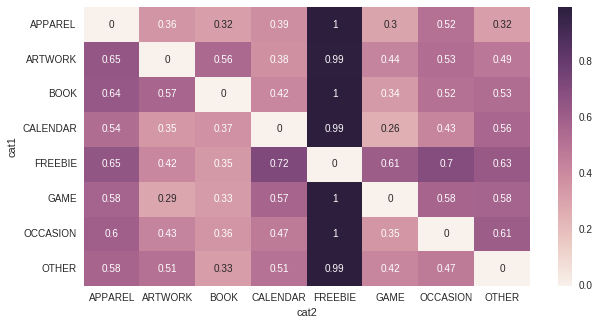

In [25]:
ctab = df_result_cf[df_result_cf.method=='popular'].pivot(index='cat1',columns='cat2',values='cv').fillna(0)
sns.heatmap(ctab,annot=True);

#### Success rates of the UBCF recommendation models

This model makes a better recommendations in CALENDER and OCCASION.

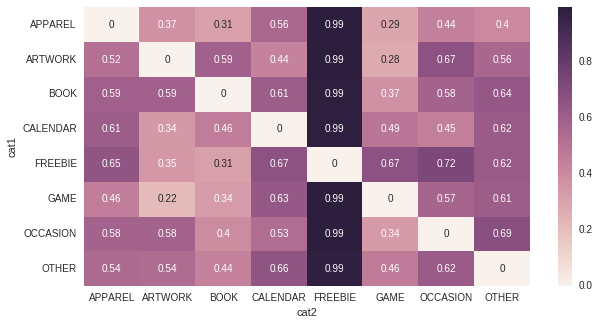

In [26]:
ctab = df_result_cf[(df_result_cf.method=='UBCF') & (df_result_cf.k==50) & (df_result_cf.metric=='cosine')].pivot(index='cat1',columns='cat2',values='cv').fillna(0)
sns.heatmap(ctab,annot=True);

#### Success rates of the IBCF recommendation models

The success rates are quite similar to the ones of UBCF.

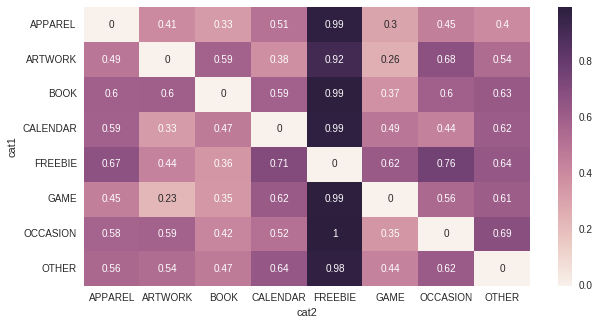

In [27]:
ctab = df_result_cf[(df_result_cf.method=='IBCF') & (df_result_cf.k==50) & (df_result_cf.metric=='common')].pivot(index='cat1',columns='cat2',values='cv').fillna(0)
sns.heatmap(ctab,annot=True);

## Conclusion

- There are some cases where the popular item model gives the best success rates. But UBCF and IBCF are better in most cases.
- The choice of the formula for a similarity degree is also important.
- If I implement a recommender system for our dataset as a product, I choose IBCF for all pairs of categories. 